## ASK591: NicheNet preparations

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

# custom functions
import sc_toolbox as sct

Running Scanpy 1.8.2, on 2022-02-09 15:41.


In [2]:
## path variables
adata_dir = '/home/niklas/data/210514_IPF_atlas_human/210611_in_vivo_reference_NIKLAS.h5ad'
project_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo/01_data/NicheNet_inputs/'

In [3]:
## plotting variables
sc.settings.figdir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo/02_figures/'
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## load anndata object
adata = sc.read(adata_dir)

In [5]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 561279 × 61661
    obs: 'data_set', 'disease', 'enriched', 'health_state', 'in_integrated', 'name', 'patient', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_1', 'louvain_2', 'domain', 'cell_type', 'meta_celltype', 'patient_id', 'disease_long', 'age', 'age_status', 'gender', 'internal_id', 'smoke_status', 'ever_smoker', 'published_cell_type', 'published_category', 'integrated', 'disease_patient', 'dge_celltype', 'cell_type_group', 'cell_type_niklas'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'mean-3', 'std-3', 'mean-4', 'std-4', 'highly_variable'
    uns: 'cell_type_colors', 'cell_type_group_colors', 'cell_type_niklas_colors', 'data_set_colors', 'dge_celltype_colors', 'domain_colors', 'health_state_colors', 'meta_celltype_colors', 'neighbors', 'pca', 'published_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    

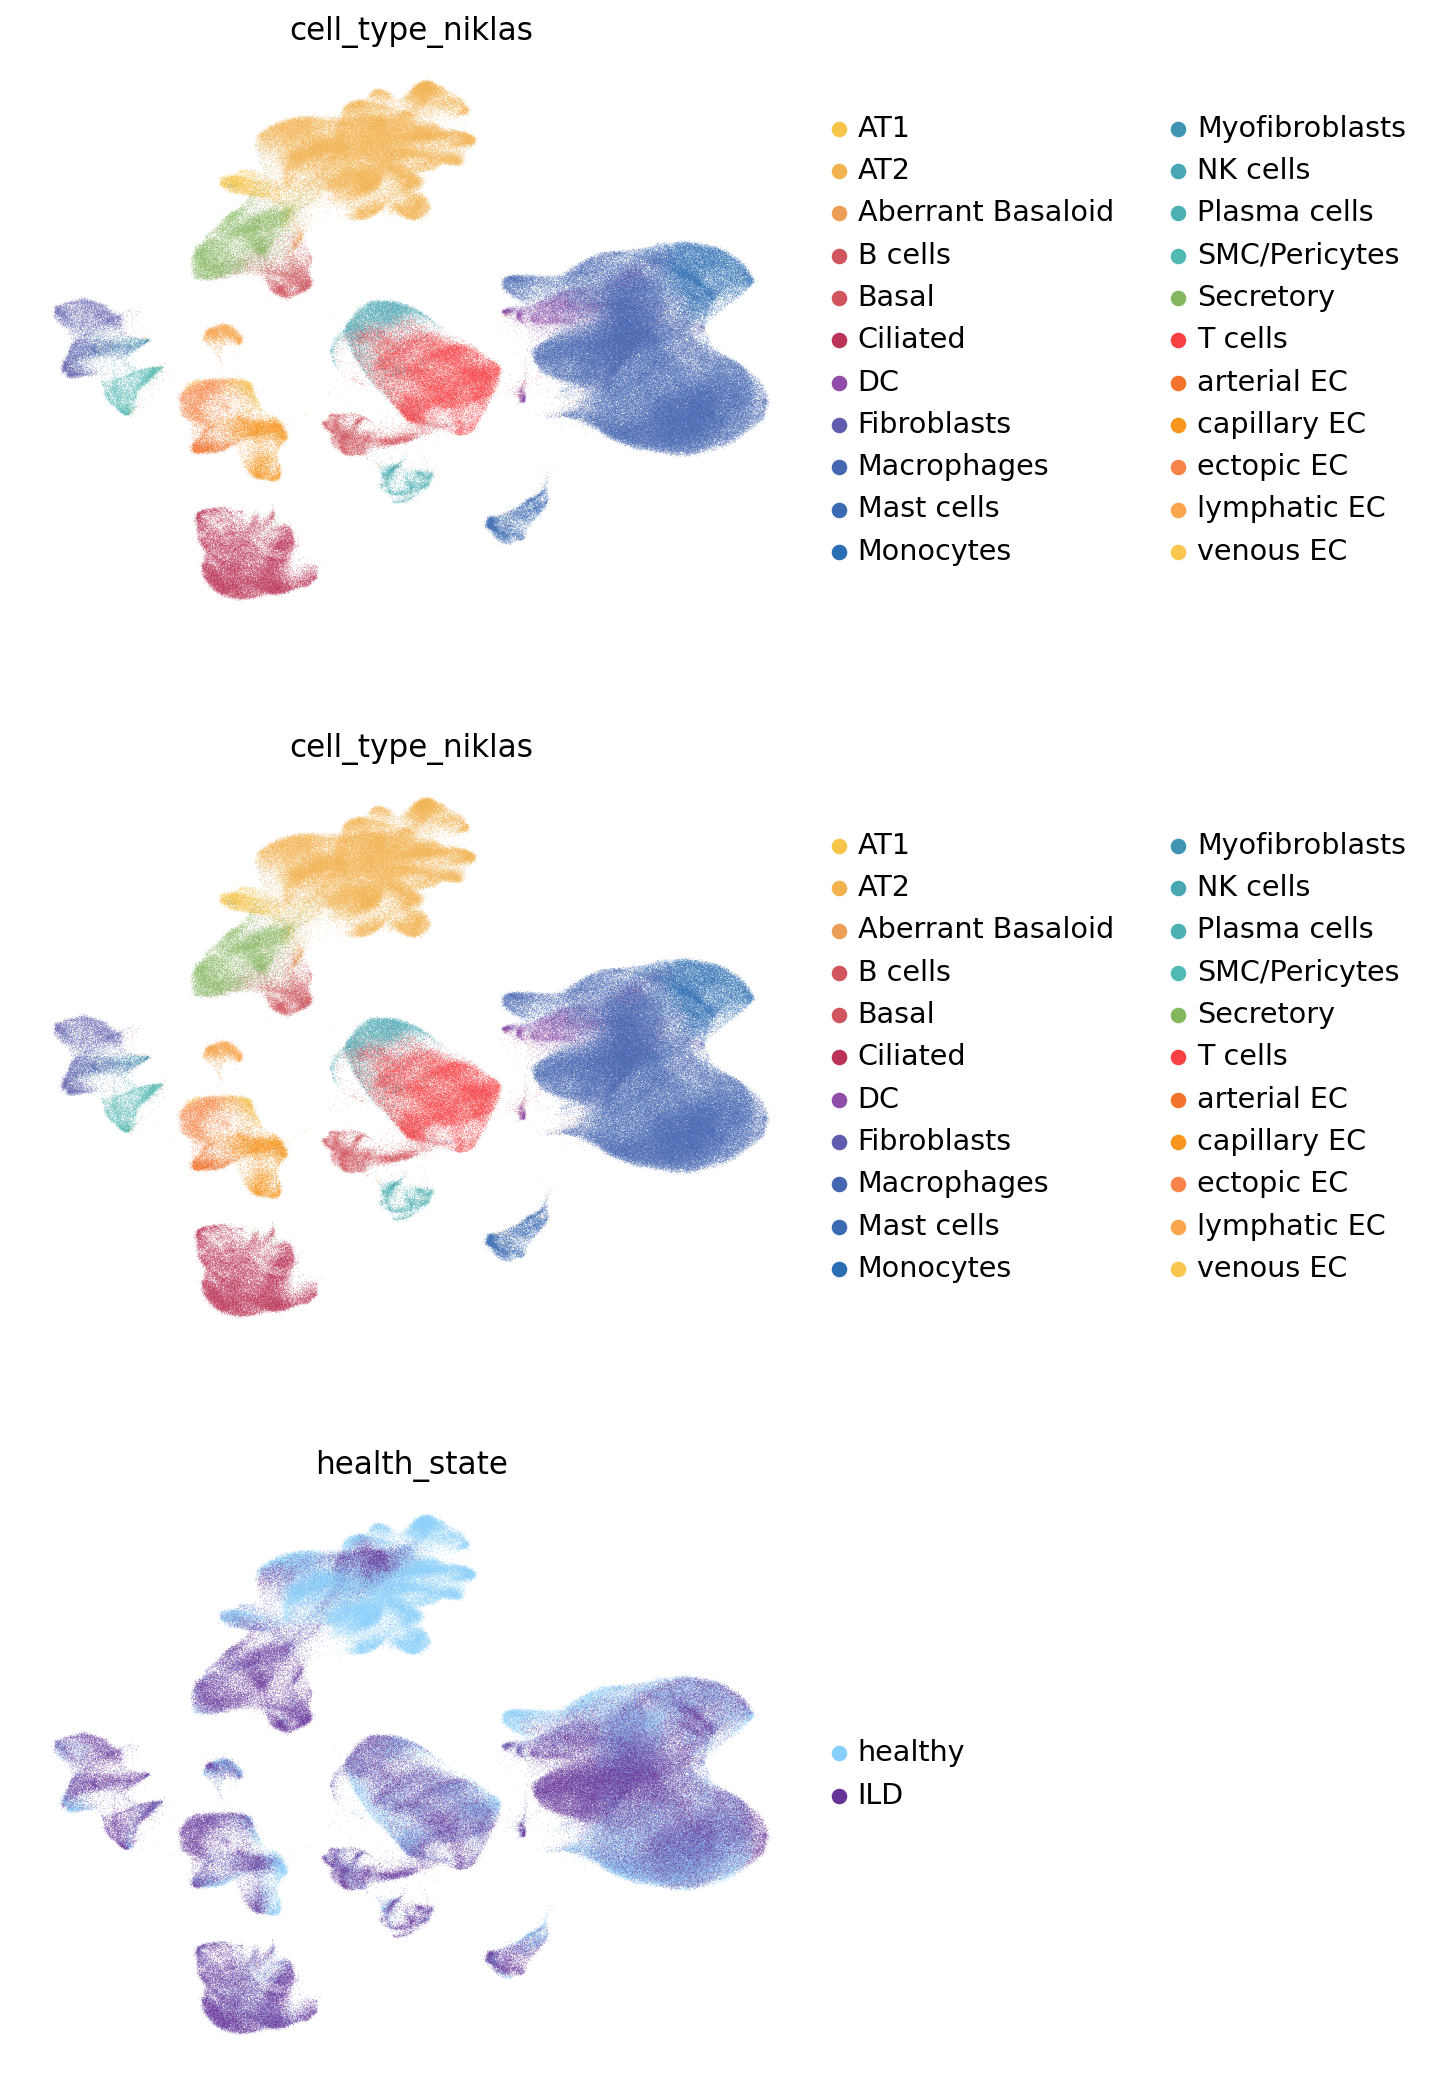

In [6]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type_niklas',
                           'cell_type_niklas',
                          'health_state'], ncols = 1, frameon = False)

In [7]:
### get overview of cell type proportions and numbers
pd.crosstab(adata.obs['cell_type_niklas'],adata.obs['health_state'])

health_state,healthy,ILD
cell_type_niklas,,
AT1,3636,2222
AT2,94895,16653
Aberrant Basaloid,22,901
B cells,1798,8681
Basal,566,8273
Ciliated,5447,29630
DC,2821,13814
Fibroblasts,2660,8284
Macrophages,82086,117611


### Calculate average expression table

In [8]:
## for each condition separately
for health_state in ['healthy','ILD']:
    adata_sub = adata[adata.obs.health_state.isin([health_state])].copy()
    avg_expr_ct = pd.DataFrame(columns=adata_sub.var_names, index=adata_sub.obs['cell_type_niklas'].cat.categories)                                                                                                 
    for cell_type in adata_sub.obs.cell_type_niklas.cat.categories: 
        avg_expr_ct.loc[cell_type] = adata_sub[adata_sub.obs['cell_type_niklas'].isin([cell_type]),:].X.mean(0)
    avg_expr_ct = avg_expr_ct.transpose()
    avg_expr_ct_SCALED = avg_expr_ct.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 1)
    avg_expr_ct.to_csv(project_dir + '220207_IPF_atlas_invivo_' + health_state + '_avg_expr_cell_type_level.csv')
    avg_expr_ct_SCALED.to_csv(project_dir + '220207_IPF_atlas_invivo_' + health_state + '_avg_expr_SCALED_cell_type_level.csv')

In [9]:
## for each health_state separately - but always pooled with CC
for health_state in ['ILD']:
    adata_sub = adata[adata.obs.health_state.isin(['healthy',health_state])].copy()
    avg_expr_ct = pd.DataFrame(columns=adata_sub.var_names, index=adata_sub.obs['cell_type_niklas'].cat.categories)                                                                                                 
    for cell_type in adata_sub.obs.cell_type_niklas.cat.categories: 
        avg_expr_ct.loc[cell_type] = adata_sub[adata_sub.obs['cell_type_niklas'].isin([cell_type]),:].X.mean(0)
    avg_expr_ct = avg_expr_ct.transpose()
    avg_expr_ct_SCALED = avg_expr_ct.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 1)
    avg_expr_ct.to_csv(project_dir + '220207_IPF_atlas_invivo_' + health_state + '_avg_expr_cell_type_level.csv')
    avg_expr_ct_SCALED.to_csv(project_dir + '220207_IPF_atlas_invivo_' + health_state + '_avg_expr_SCALED_cell_type_level.csv')

### Calculate pct expression tables

In [10]:
## for each condition separately
for health_state in ['healthy','ILD']:
    adata_sub = adata[adata.obs.health_state.isin([health_state])].copy()
    pct_expr_ct = pd.DataFrame(columns=adata_sub.raw.var_names, index=adata_sub.obs['cell_type_niklas'].cat.categories) 
    for cell_type in adata_sub.obs.cell_type_niklas.cat.categories:
        cells = adata_sub.obs_names[adata_sub.obs['cell_type_niklas'] == cell_type]
        pct_expr_ct.loc[cell_type] = (adata_sub.raw[cells].X > 0).sum(0) / adata_sub.raw[cells].X.shape[0]
    pct_expr_ct = pct_expr_ct.transpose()
    pct_expr_ct.to_csv(project_dir + '220207_IPF_atlas_invivo_' + health_state + '_pct_expr_cell_type_level.csv')

In [11]:
## for each health_state separately - but always pooled with CC
for health_state in ['ILD']:
    adata_sub = adata[adata.obs.health_state.isin(['healthy',health_state])].copy()
    pct_expr_ct = pd.DataFrame(columns=adata_sub.raw.var_names, index=adata_sub.obs['cell_type_niklas'].cat.categories) 
    for cell_type in adata_sub.obs.cell_type_niklas.cat.categories:
        cells = adata_sub.obs_names[adata_sub.obs['cell_type_niklas'] == cell_type]
        pct_expr_ct.loc[cell_type] = (adata_sub.raw[cells].X > 0).sum(0) / adata_sub.raw[cells].X.shape[0]
    pct_expr_ct = pct_expr_ct.transpose()
    pct_expr_ct.to_csv(project_dir + '220207_IPF_atlas_invivo_' + health_state + '_pct_expr_cell_type_level.csv')